## Goal: Develop clustering methods that utilize the Urerf similarity matrix output.

Develop and run spectral embedding on the Urerf similarity matrix output and then cluster with Mini Batch K-Means, Gaussian Mixture Model, or other algorithms.
Explore clustering algorithms that directly take in a similarity matrix such as Affinity Propagation, DBSCAN, etc.

DoD:

  1. All clustering algorithms listed above developed. (using Sklearn)
  2. Visualization of potential methods for clustering the Urerf similarity matrix output using similarity matrix algorithms (Affinity Propagation, DBSCAN, Agglomerative Clustering)
  3. Visualization of potential methods for clustering the Urerf similarity matrix using spectral embedding followed by clustering algorithms (K-means (regular or mini batch), GMM)
  4. Application of techniques on HBN/HNU data (optional)


### 1. All clustering algorithms listed above developed. (using Sklearn)

The algorithms vary the number of clusters (either direcctly or by using the parameter that most controls the number of clusters produced). All trials are outputted as well as the highest achieved ARI and the associated best number of clusters. 

All clustering algorithms are located in cluster.py.



In [1]:
## Imports ##
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.manifold import SpectralEmbedding
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn import datasets
from sklearn.preprocessing import normalize

#### The clustering Algorithms ####
from cluster import AffinityProp_BestSil
from cluster import AgglomerativeClustering_BestSil
from cluster import DBSCANClustering_BestSil
from cluster import MiniBatch_BestSil
from cluster import GMM_BestSil
from cluster import AffinityProp_BestAri
from cluster import AgglomerativeClustering_BestAri
from cluster import DBSCANClustering_BestAri
from cluster import MiniBatch_BestAri
from cluster import GMM_BestAri

## Code for clustering and plotting 2D data examples

In [2]:
np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

def plotClusteredData(X, clustering_algorithms, input_files, dataset_list, dim):
    
    # ============
    # Set up the figure parameters
    # ============
    
    plt.figure(figsize=(len(clustering_algorithms) * 2 + (len(clustering_algorithms)/2), 12.5))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,hspace=.01)
    plot_num = 1
    
        
    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            
            fname = input_files[i_dataset]
            matrix = open('../input/' + fname, 'r').read()
            matrix = [item.split() for item in matrix.split('\n')[:-1]]
            inputMat = np.matrix(matrix, dtype = float)
            if name[0:8] == 'Spectral':
                embedding = SpectralEmbedding(n_components = dim[name], affinity = 'precomputed')
                X_ = embedding.fit_transform(inputMat)
                algorithm.fit(X_)
            elif name[-4:] == 'Dist':
                maxElement = X_.max()
                X_Dist = 1 - (X_/maxElement)
                algorithm.fit(X_Dist)
            elif name[-3:] == 'Sim':
                X_ = inputMat
                algorithm.fit(X_)
            elif name[-9:] == 'DistSpect':
                embedding = SpectralEmbedding(n_components = dim[name], affinity = 'precomputed')
                X_ = embedding.fit_transform(inputMat)
            else:
                algorithm.fit(X)
                
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            if name[0:8] == 'Spectral' or name[-3:] == 'Sim' or name[-8:] == 'DistSpect':
                y_pred = algorithm.predict(X_)
            elif name[-4:] == 'Dist':
                y_pred = algorithm.predict(X_Dist)
            else:
                y_pred = algorithm.predict(X)

            
        plt.subplot(len(dataset_list), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                            '#f781bf', '#a65628', '#984ea3',
                                            '#999999', '#e41a1c', '#dede00']),
                                          int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
            transform=plt.gca().transAxes, size=15,
            horizontalalignment='right')
        plot_num += 1



## Plotting functions

In [3]:
def plotMultipleDims(dataMatrix, colors, dim, trial_num):
    for i in range(trial_num * len(dim)):
        mat_ = np.matrix(np.vstack(dataMatrix[i][1]))
        dimension = dataMatrix[i][0]
        if i%trial_num == 0:
            plt.scatter(mat_[:,0].tolist(), mat_[:,1].tolist(), c = colors[dim.index(dimension)], label=dimension)
        else:
            plt.scatter(mat_[:,0].tolist(), mat_[:,1].tolist(), c = colors[dim.index(dimension)])
def plotReg(dataMatrices, labels, ylab, xlab, colors):
    for i in range(len(dataMatrices)):
        dat = dataMatrices[i]
        plt.scatter(dat[:,0].tolist(), dat[:,1].tolist(), c = colors[i], label=labels[i])
    plt.ylabel(ylab)
    plt.xlabel(xlab)

## 2. Visualization of potential methods for clustering the Urerf similarity matrix output using similarity matrix algorithms (Affinity Propagation, DBSCAN, Agglomerative Clustering, etc.)

This was done in 2 ways. 
     - First, the Sklearn toy datasets were used to visualize results on 2D data.
     - Second, the same algorithms were run on the Iris data set and silhouette score plotted against number of clusters.
     
All of the data has already been run through Urerf and the resultant data files are included.

The parameters for Urerf were set as follows:

~~~~
numtrees <- 500
k <- 10
depth <- 4
~~~~

Each algorithm was either given the similarity matrix output of Urerf or the distance matrix transformation of the Urerf output based on their input requirements.

A parameter sweep was performed for affinity propagation and DBSCAN but neither was able to acheive a reasonable number of clusters. 

The following plots then demonstrate the increased viability of Agglomerative clustering over DBSCAN and affinity propagation when run on the Urerf output. 

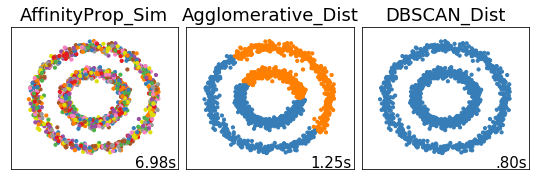

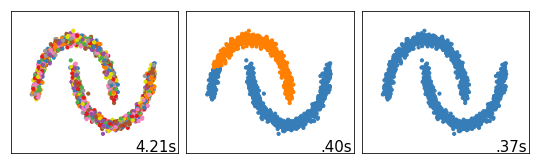

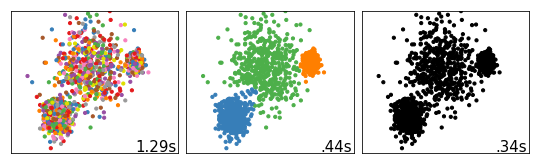

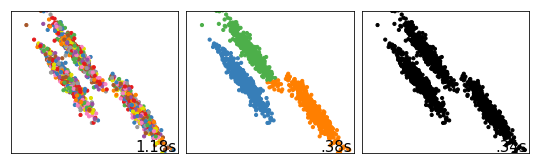

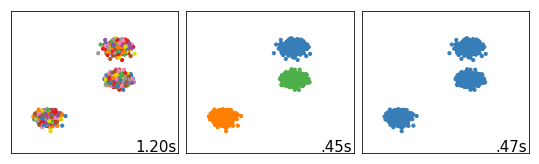

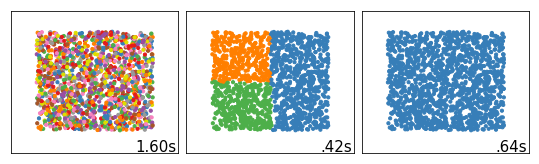

In [11]:
files = ['sampleNew0.txt','sampleNew1.txt','sampleNew2.txt','sampleNew3.txt','sampleNew4.txt','sampleNew5.txt']

default_base = {'quantile': .3,
                'eps': 9.0,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

dataset_list = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

dim = None

for i_dataset, (dataset, algo_params) in enumerate(dataset_list):
    
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    # ============
    # Create cluster objects
    # ============
    dbscan = cluster.DBSCAN(eps=params['eps'], metric ='precomputed')
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference = params['preference'], affinity = 'precomputed')
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity = 'precomputed',
        n_clusters=params['n_clusters'])

    clustering_algorithms = (
        ('AffinityProp_Sim', affinity_propagation),
        ('Agglomerative_Dist', average_linkage),
        ('DBSCAN_Dist', dbscan)
    )

    plotClusteredData(X, clustering_algorithms, files, dataset_list, dim)

plt.show()

For the Iris data the parameters for Urerf were similarly set as follows:

~~~~
numtrees <- 500
k <- 10
depth <- 4
~~~~

This was after it was shown that the k-value and depth do not show much impact on the ARI. 

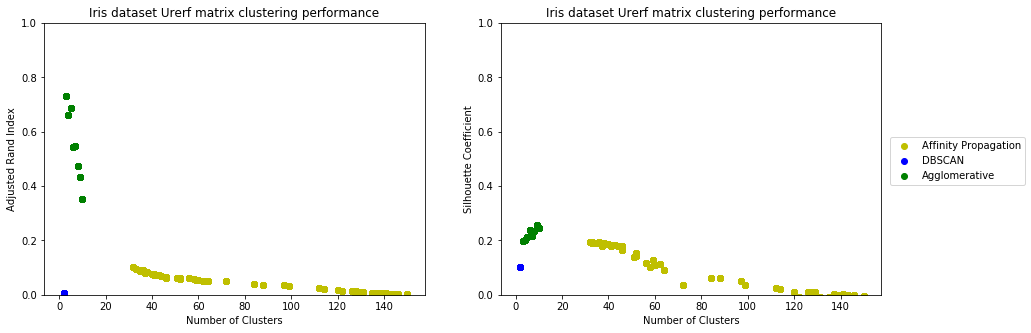

In [5]:
# Set parameters for the test #
trial_num = 10 # Note number of trials and range of parameter span was reduced to improve runtime of final deliverable
t = float(trial_num)

# Load the similarity matrix #
fname = '../input/inTestMat.txt'
matrix = open(fname, 'r').read()
matrix = [item.split() for item in matrix.split('\n')[:-1]]
inputMat = np.matrix(matrix, dtype = float)
inputMat_transformed = 1 - (inputMat/inputMat.max())

iris = datasets.load_iris()

# Lists to hold all of the trials #
af_data_sil = []
ag_data_sil = []
db_data_sil = []
af_data_ari = []
ag_data_ari = []
db_data_ari = []

# Call clustering functions which vary the number of clusters from 1 to 10 or the preference and epsilon parameters #
# which vary from their initial values below to the maximum element in each matrix #
for i in range(trial_num):
    maxPre, maxSilAf, trials_Af = AffinityProp_BestSil(inputMat, damp = .9, preferenceInit = 0.0, preferenceInc = .05)
    bestClustAg, maxSilAg, trials_Ag = AgglomerativeClustering_BestSil(inputMat_transformed, clustInit = 2, clustInc = 1, clustMax = 10)
    maxEps, maxSilDb, trials_Db = DBSCANClustering_BestSil(inputMat_transformed, epsInit = 0, epsInc = 0.05)
    af_data_sil.append(trials_Af)
    ag_data_sil.append(trials_Ag)
    db_data_sil.append(trials_Db)
    
    maxPre, maxAriAf, trials_Af = AffinityProp_BestAri(inputMat, iris.target, damp = .9, preferenceInit = 0.0, preferenceInc = .05)
    bestClustAg, maxAriAg, trials_Ag = AgglomerativeClustering_BestAri(inputMat_transformed, iris.target, clustInit = 2, clustInc = 1, clustMax = 10)
    maxEps, maxAriDb, trials_Db = DBSCANClustering_BestAri(inputMat_transformed, iris.target, epsInit = 0, epsInc = 0.05)
    af_data_ari.append(trials_Af)
    ag_data_ari.append(trials_Ag)
    db_data_ari.append(trials_Db)
    
    
# Plot the results #

af_data_ari = np.matrix(np.vstack(af_data_ari))
ag_data_ari = np.matrix(np.vstack(ag_data_ari))
db_data_ari = np.matrix(np.vstack(db_data_ari))
af_data_sil = np.matrix(np.vstack(af_data_sil))
ag_data_sil = np.matrix(np.vstack(ag_data_sil))
db_data_sil = np.matrix(np.vstack(db_data_sil))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Iris dataset Urerf matrix clustering performance')
plotReg([af_data_ari, db_data_ari, ag_data_ari], ["Affinity Propagation",'DBSCAN', 'Agglomerative'],'Adjusted Rand Index','Number of Clusters', ['y','b', 'g'])
ax = plt.gca()
ax.set_ylim(0.0,1.0)


plt.subplot(1,2,2)
plt.title('Iris dataset Urerf matrix clustering performance')
plotReg([af_data_sil, db_data_sil, ag_data_sil], ["Affinity Propagation",'DBSCAN', 'Agglomerative'],'Silhouette Coefficient','Number of Clusters', ['y','b','g'])
ax = plt.gca()
ax.set_ylim(0.0,1.0)
plt.legend(loc=9, bbox_to_anchor=(1.2, 0.6))

## 3. Visualization of potential methods for clustering the Urerf similarity matrix using spectral embedding followed by clustering algorithms (K-means (regular or mini batch), GMM)

This was done in 2 ways. 
     - First, the Sklearn toy datasets were used to visualize results on 2D data for varying dimensional embeddings.
     - Second, the same algorithms were run on the Iris data set. The dimensions chosen were 2 and 5 based on highest performance. 
     
All of the data has already been run through Urerf and the resultant data files are included.

The Toy dataset results show how the imbedding dimension affects performance on the 2 dimensional data.

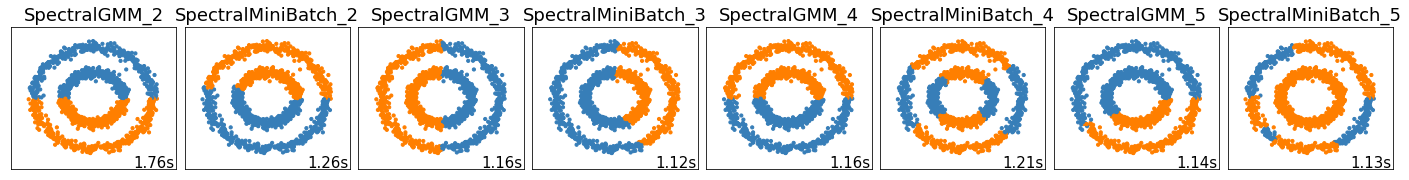

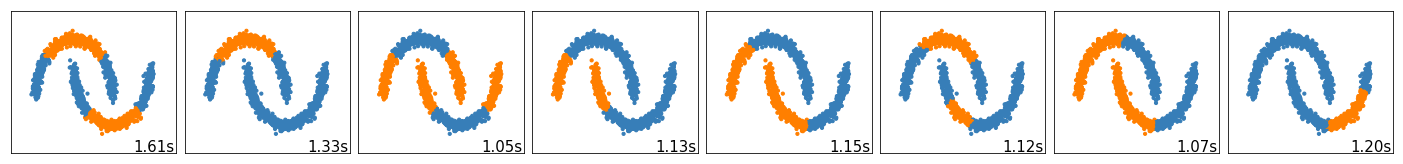

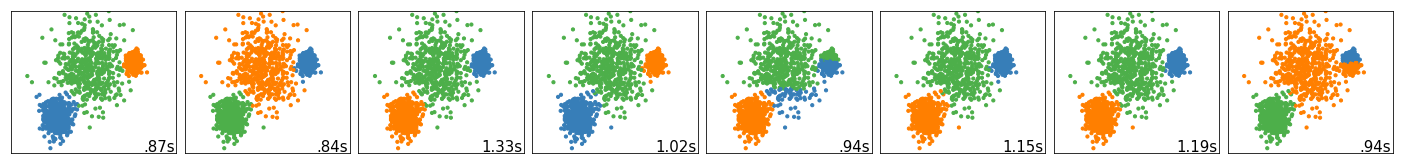

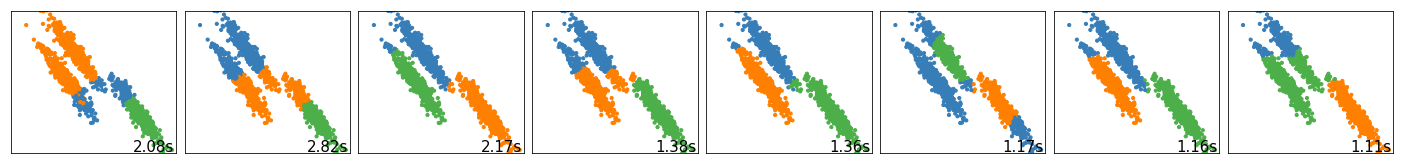

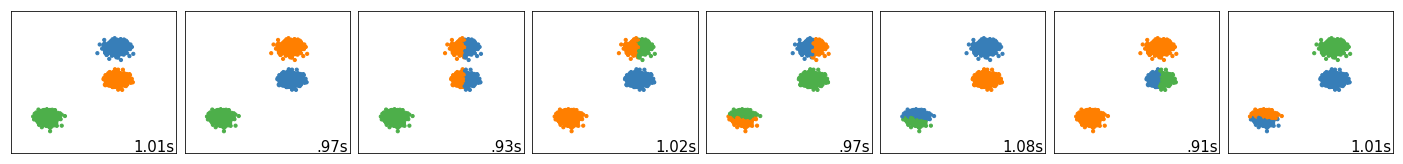

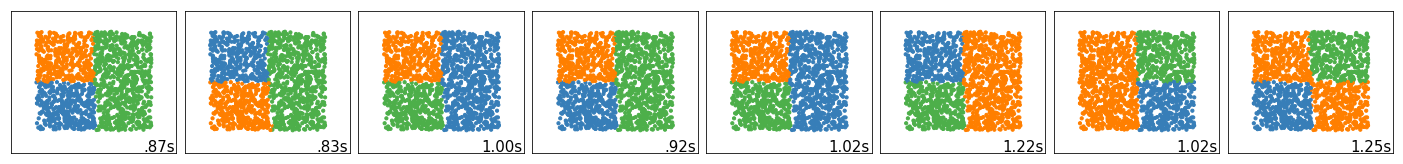

In [6]:
files = ['sampleNew0.txt','sampleNew1.txt','sampleNew2.txt','sampleNew3.txt','sampleNew4.txt','sampleNew5.txt']

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

dataset_list = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

dim = {'SpectralGMM_2':2,'SpectralMiniBatch_2':2,'SpectralGMM_3':3,'SpectralMiniBatch_3':3,'SpectralGMM_4':4,'SpectralMiniBatch_4':4,'SpectralGMM_5':5,'SpectralMiniBatch_5':5}

for i_dataset, (dataset, algo_params) in enumerate(dataset_list):
    
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('SpectralGMM_2', gmm),
        ('SpectralMiniBatch_2', two_means),
        ('SpectralGMM_3', gmm),
        ('SpectralMiniBatch_3', two_means),
        ('SpectralGMM_4', gmm),
        ('SpectralMiniBatch_4', two_means),
        ('SpectralGMM_5', gmm),
        ('SpectralMiniBatch_5', two_means),
    )
    
    plotClusteredData(X, clustering_algorithms, files, dataset_list, dim)

plt.show()

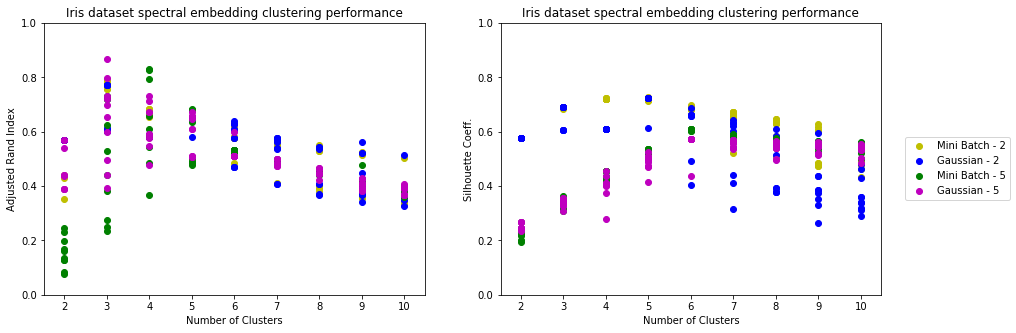

In [7]:
# Set parameters for the test #
trial_num = 10 # Note number of trials and range of parameter span was reduced to improve runtime of final deliverable
t = float(trial_num)
n = 2
correctLabels = iris.target

# Load the data #
fname = '../input/inTestMat.txt'
matrix = open(fname, 'r').read()
matrix = [item.split() for item in matrix.split('\n')[:-1]]
inputMat = np.matrix(matrix, dtype = float)
embedding = SpectralEmbedding(n_components=n, affinity = 'precomputed')
inputMat_embedded = embedding.fit_transform(inputMat)

# Lists to hold all of the trials #
gmm_data_sil_2 = []
mini_data_sil_2 = []
gmm_data_ari_2 = []
mini_data_ari_2 = []

# Call clustering functions which vary the number of clusters from 1 to 20 or the preference and epsilon parameters #
# which vary from their initial values below to the maximum element in each matrix #

for i in range(trial_num):
    
    bestClustGMM, maxSilGMM, trials_GMM = GMM_BestSil(inputMat_embedded, clustInit = 1, clustInc = 1, clustMax = 10)
    bestClustMini, maxSilMini, trials_Mini = MiniBatch_BestSil(inputMat_embedded, clustInit = 1, clustInc = 1, batchSize = 75, clustMax = 10)
    gmm_data_sil_2.append(trials_GMM)
    mini_data_sil_2.append(trials_Mini)
    
    bestClustGMM, maxAriGMM, trials_GMM = GMM_BestAri(inputMat_embedded, correctLabels, clustInit = 1, clustInc = 1, clustMax = 10)
    bestClustMini, maxAriMini, trials_Mini = MiniBatch_BestAri(inputMat_embedded, correctLabels, clustInit = 1, clustInc = 1, batchSize = 75, clustMax = 10)
    gmm_data_ari_2.append(trials_GMM)
    mini_data_ari_2.append(trials_Mini)
    
# Now embedding into 5 dimensions #

n = 5
embedding = SpectralEmbedding(n_components=n, affinity = 'precomputed')
inputMat_embedded = embedding.fit_transform(inputMat)

# Lists to hold all of the trials #
gmm_data_sil_5 = []
mini_data_sil_5 = []
gmm_data_ari_5 = []
mini_data_ari_5 = []

for i in range(trial_num):
    
    bestClustGMM, maxSilGMM, trials_GMM = GMM_BestSil(inputMat_embedded, clustInit = 1, clustInc = 1, clustMax = 10)
    bestClustMini, maxSilMini, trials_Mini = MiniBatch_BestSil(inputMat_embedded, clustInit = 1, clustInc = 1, batchSize = 75, clustMax = 10)
    gmm_data_sil_5.append(trials_GMM)
    mini_data_sil_5.append(trials_Mini)
    
    bestClustGMM, maxAriGMM, trials_GMM = GMM_BestAri(inputMat_embedded, correctLabels, clustInit = 1, clustInc = 1, clustMax = 10)
    bestClustMini, maxAriMini, trials_Mini = MiniBatch_BestAri(inputMat_embedded, correctLabels, clustInit = 1, clustInc = 1, batchSize = 75, clustMax = 10)
    gmm_data_ari_5.append(trials_GMM)
    mini_data_ari_5.append(trials_Mini)
    

mini_data_ari_2 = np.matrix(np.vstack(mini_data_ari_2))
gmm_data_ari_2 = np.matrix(np.vstack(gmm_data_ari_2))
mini_data_sil_2 = np.matrix(np.vstack(mini_data_sil_2))
gmm_data_sil_2 = np.matrix(np.vstack(gmm_data_sil_2))

mini_data_ari_5 = np.matrix(np.vstack(mini_data_ari_5))
gmm_data_ari_5 = np.matrix(np.vstack(gmm_data_ari_5))
mini_data_sil_5 = np.matrix(np.vstack(mini_data_sil_5))
gmm_data_sil_5 = np.matrix(np.vstack(gmm_data_sil_5))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Iris dataset spectral embedding clustering performance')
plotReg([mini_data_ari_2, gmm_data_ari_2, mini_data_ari_5, gmm_data_ari_5], ['Mini Batch - 2', 'Gaussian - 2','Mini Batch - 5', 'Gaussian - 5'],'Adjusted Rand Index','Number of Clusters', ['y','b','g','m'])
ax = plt.gca()
ax.set_ylim(0.0,1.0)


plt.subplot(1,2,2)
plt.title('Iris dataset spectral embedding clustering performance')
plotReg([mini_data_sil_2, gmm_data_sil_2, mini_data_sil_5, gmm_data_sil_5], ['Mini Batch - 2', 'Gaussian - 2','Mini Batch - 5', 'Gaussian - 5'],'Silhouette Coeff.','Number of Clusters', ['y','b','g','m'])
ax = plt.gca()
ax.set_ylim(0.0,1.0)
plt.legend(loc=9, bbox_to_anchor=(1.2, 0.6))

## 4. Application of algorithms to HBN/HNU

The following shows two applications of the algorithms shown above to the HNU and HBN data.

The first application is as follows:

Input: HNU flattened adjacency matrix upper triangle

1. Urerf was run on the flattened adjacency matrices of each HNU graph
2. The following algorithms were applied as exemplified above:
    a. agglomerative clustering on the distance matrix 
    b. GMM on the embedded similarity matrix (5 dimensions used)
    c. Mini Batch K Means on the embedded similarity matrix (5 dimensions used)
3. Evaluated utilizing ARI with labels as individual ID's
    
The second application is as follows:

Input: HBN vertex feature matrix

1. Urerf was run on the HBN vertex feature matrix produced by Vivek
2. The following algorithms were applied as exemplified above:
    a. agglomerative clustering on the distance matrix 
    b. GMM on the embedded similarity matrix (5 dimensions used)
    c. Mini Batch K Means on the embedded similarity matrix (5 dimensions used)
3. Evaluated using Silhouette Coefficient (no 'correct' answer per say)

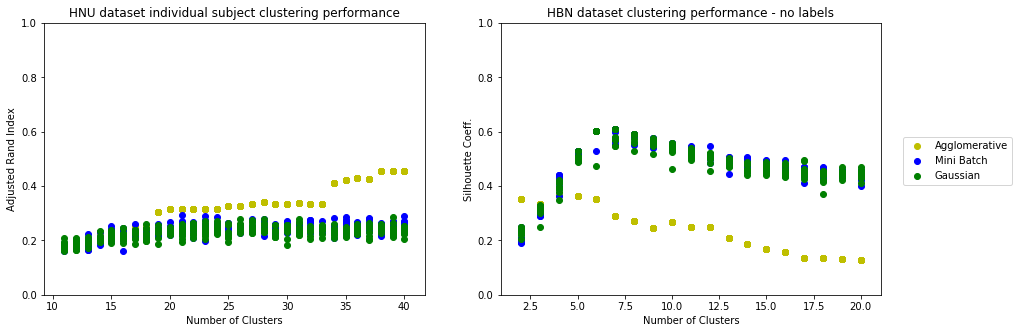

In [12]:
# Load Similarity Matrix from Urerf #
matrix = open('../input/outfileSimMat_HNU_d.txt').read()
matrix = [item.split() for item in matrix.split('\n')[:-1]]
inputMat = np.matrix(matrix, dtype = float)

# Load HNU labels #
matrix = open('../input/HNU_labels.txt').read()
correctLabels = [item for item in matrix.split('\n')[:-1]]

# Set parameters for the test #
trial_num = 10
t = float(trial_num)
n = 5

# Transform the similarity matrix #

inputMat_transformed = 1 - (inputMat/inputMat.max())

embedding = SpectralEmbedding(n_components=n, affinity = 'precomputed')
inputMat_embedded = embedding.fit_transform(inputMat)

# Lists to hold all of the trials #
ag_data_ari = []
gmm_data_ari = []
mini_data_ari = []

# Call clustering functions which vary the number of clusters from 1 to 20 or the preference and epsilon parameters #
# which vary from their initial values below to the maximum element in each matrix #
for i in range(trial_num):
   
    bestClustAg, maxAriAg, trials_Ag = AgglomerativeClustering_BestAri(inputMat_transformed, correctLabels, clustInit = 10, clustInc = 1, clustMax = 40)
    ag_data_ari.append(trials_Ag)
    
    bestClustGMM, maxAriGMM, trials_GMM = GMM_BestAri(inputMat_embedded, correctLabels, clustInit = 10, clustInc = 1, clustMax = 40)
    bestClustMini, maxAriMini, trials_Mini = MiniBatch_BestAri(inputMat_embedded, correctLabels, clustInit = 10, clustInc = 1, batchSize = 75, clustMax = 40)
    gmm_data_ari.append(trials_GMM)
    mini_data_ari.append(trials_Mini)
    

# Load the urerf vertex stats output #
matrix = open('../input/hbn_vertexstats_mat.txt').read()
matrix = [item.split() for item in matrix.split('\n')[:-1]]
inputMat = np.matrix(matrix, dtype = float)

# Set parameters for the test #
trial_num = 10
t = float(trial_num)
n = 5

# Transform the similarity matrix #

inputMat_transformed = 1 - (inputMat/inputMat.max())

embedding = SpectralEmbedding(n_components=n, affinity = 'precomputed')
inputMat_embedded = embedding.fit_transform(inputMat)

# Lists to hold all of the trials #
ag_data_sil = []
gmm_data_sil = []
mini_data_sil = []

# Call clustering functions which vary the number of clusters from 1 to 20 or the preference and epsilon parameters #
# which vary from their initial values below to the maximum element in each matrix #
for i in range(trial_num):
    bestClustAg, maxSilAg, trials_Ag = AgglomerativeClustering_BestSil(inputMat_transformed, clustInit = 1, clustInc = 1, clustMax = 20)
    ag_data_sil.append(trials_Ag)
    
    bestClustGMM, maxSilGMM, trials_GMM = GMM_BestSil(inputMat_embedded, clustInit = 1, clustInc = 1, clustMax = 20)
    bestClustMini, maxSilMini, trials_Mini = MiniBatch_BestSil(inputMat_embedded, clustInit = 1, clustInc = 1, batchSize = 75, clustMax = 20)
    gmm_data_sil.append(trials_GMM)
    mini_data_sil.append(trials_Mini)
    
ag_data_ari = np.matrix(np.vstack(ag_data_ari))
ag_data_sil = np.matrix(np.vstack(ag_data_sil))

mini_data_ari = np.matrix(np.vstack(mini_data_ari))
gmm_data_ari = np.matrix(np.vstack(gmm_data_ari))
mini_data_sil = np.matrix(np.vstack(mini_data_sil))
gmm_data_sil = np.matrix(np.vstack(gmm_data_sil))


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('HNU dataset individual subject clustering performance')
plotReg([ag_data_ari, mini_data_ari, gmm_data_ari], ['Agglomerative', 'Mini Batch', 'Gaussian'],'Adjusted Rand Index','Number of Clusters', ['y','b','g'])
ax = plt.gca()
ax.set_ylim(0.0,1.0)


plt.subplot(1,2,2)
plt.title('HBN dataset clustering performance - no labels')
plotReg([ag_data_sil, mini_data_sil, gmm_data_sil], ['Agglomerative', 'Mini Batch', 'Gaussian'],'Silhouette Coeff.','Number of Clusters', ['y','b','g'])
ax = plt.gca()
ax.set_ylim(0.0,1.0)
plt.legend(loc=9, bbox_to_anchor=(1.2, 0.6))